# Research the correlation between PFT and torso

In [1]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd
import json


/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jjia/.local/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [117]:
pft_fpath = '/home/jjia/data/dataset/lung_function/SScBaseline_PFT_anonymized_with_percent.xlsx'  # id from 0068800 to 99..., total 333 cases
label_excel = pd.read_excel(pft_fpath, engine='openpyxl')
label_excel = label_excel.sort_values(by=['subjectID'])


In [118]:
label_excel

,subjectID,scandate,TLC_Lres,DateDF_abs,ScanDate,PFT Date,Date of Birth,Gender,Age,Height,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,FVCPP,DLCOcPP,FEV1PP,TLCPP
122,SSc_patient_0068800,20110701,YES,1.0,2011-07-01,2011-06-30,1951-12-07,female,60.0,1.81,...,NaN,NaN,NaN,NaN,NaN,NaN,108,83,111,95
123,SSc_patient_0127512,20091127,YES,1.0,2009-11-27,2009-11-26,1931-03-07,female,78.0,1.56,...,NaN,NaN,NaN,NaN,NaN,NaN,88,68,87,87
124,SSc_patient_0139552,20121102,YES,1.0,2012-11-02,2012-11-01,1939-06-17,female,73.0,1.71,...,NaN,NaN,NaN,NaN,NaN,NaN,115,73,112,105
125,SSc_patient_0143788,20090529,YES,0.0,2009-05-28,2009-05-28,1942-09-12,female,68.0,1.70,...,NaN,NaN,NaN,NaN,NaN,NaN,87,17,89,71
126,SSc_patient_0152440,20100604,YES,1.0,2010-06-04,2010-06-03,1946-12-23,female,64.0,1.60,...,NaN,NaN,NaN,NaN,NaN,NaN,101,110,104,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SSc_patient_9523013,20090904,YES,1.0,2009-09-04,2009-09-03,1978-10-01,male,31.0,1.80,...,NaN,NaN,NaN,NaN,NaN,NaN,80,60,82,66
121,SSc_patient_9662556,20120921,NO,1.0,2012-09-21,2012-09-20,1984-02-19,female,28.0,1.71,...,NaN,NaN,NaN,NaN,NaN,NaN,102,78,102,90
330,SSc_patient_9861781,20090417,YES,1.0,2009-04-17,2009-04-16,1958-03-03 00:00:00,male,51.0,1.77,...,NaN,NaN,NaN,NaN,NaN,NaN,100,56,100,86
331,SSc_patient_9934096,20100122,YES,1.0,2010-01-22,2010-01-21,1941-02-02,female,69.0,1.57,...,NaN,NaN,NaN,NaN,NaN,NaN,102,79,99,101


## Calculate torso/lung/vessel volume and save them to a file

In [82]:
data_dir = '/home/jjia/data/dataset/lung_function/iso1.5'

torso_files = sorted(glob(data_dir + '/*Torso.nii.gz'))
lung_files = sorted(glob(data_dir + '/*LungMask.nii.gz'))
vessel_files = sorted(glob(data_dir + '/*GcVessel.nii.gz'))


In [83]:
def volumes(files):
    volume_ls = []
    for i in files:
        lung, ori, sp = load_itk(i, require_ori_sp=True)
        lung_volume = np.sum(lung)
        volume_ls.append([i.split('SSc_patient_')[-1][:7], lung_volume])
    return volume_ls


In [85]:
torso_volumes, lung_volumes, vessel_volumes = map(volumes, [torso_files, lung_files, vessel_files])

In [86]:
len(vessel_volumes)

317

In [87]:
all_pat_id = []
all_volumes = [[] for i in range(len(torso_volumes))]
flag = True
for idx, volumes in enumerate([torso_volumes, lung_volumes, vessel_volumes]):
    global flag
    if flag:
        for i in volumes:
            all_pat_id.append([i[0]])
        flag = False
    for idx2, j in enumerate(volumes):
        all_volumes[idx2].append(j[1])


In [88]:
all_pat_id = np.array(all_pat_id)

In [89]:
all_volumes = np.array(all_volumes)

In [90]:
all = np.concatenate((all_pat_id, all_volumes), axis=1)

In [91]:
df = pd.DataFrame(all, columns=['pat_id', 'torso_volume', 'lung_volume', 'vessel_volume'])

In [92]:
df

,pat_id,torso_volume,lung_volume,vessel_volume
0,0068800,5351801.0,2273472.0,132840.0
1,0127512,5698558.0,1464888.0,103244.0
2,0139552,4955666.0,2676405.0,73081.0
3,0143788,4948448.0,1615487.0,190414.0
4,0152440,7076505.0,1789790.0,57397.0
...,...,...,...,...
312,9523013,6400296.0,2390385.0,150919.0
313,9662556,4690554.0,1874114.0,61006.0
314,9861781,5591670.0,2147462.0,160638.0
315,9934096,5823311.0,2022743.0,71400.0


In [97]:
df.set_index('pat_id')

,torso_volume,lung_volume,vessel_volume
pat_id,,,
0068800,5351801.0,2273472.0,132840.0
0127512,5698558.0,1464888.0,103244.0
0139552,4955666.0,2676405.0,73081.0
0143788,4948448.0,1615487.0,190414.0
0152440,7076505.0,1789790.0,57397.0
...,...,...,...
9523013,6400296.0,2390385.0,150919.0
9662556,4690554.0,1874114.0,61006.0
9861781,5591670.0,2147462.0,160638.0


In [145]:
df_new = pd.DataFrame(columns=['PatID', 'Torso-V', 'Lung-V','Vessel-V', 'DLCOc', 'FEV1', 'FVC', 'TLC', 'DLCOcPP', 'FEV1PP', 'FVCPP', 'TLCPP'])


In [146]:
df.columns.tolist()

['pat_id', 'torso_volume', 'lung_volume', 'vessel_volume']

In [147]:
df[df['pat_id']=='9939136']

,pat_id,torso_volume,lung_volume,vessel_volume
316,9939136,5552499.0,1509141.0,138215.0


In [148]:
a,b,c,d = df[df['pat_id']=='9939136']

In [149]:
b

'torso_volume'

In [150]:
i = 0
for idx, row in label_excel.iterrows():
    id = row['subjectID'].split('SSc_patient_')[-1][:7]
    if id in [i[0] for i in all_pat_id]:
        row_v = df[df['pat_id']==id]
        df_new.loc[i] = [id, row_v['torso_volume'].iloc[0], row_v['lung_volume'].iloc[0], row_v['vessel_volume'].iloc[0], row['DLCOc_SB'], row['FEV1'], row['FVC'], row['TLC_He'], row['DLCOcPP'], row['FEV1PP'], row['FVCPP'], row['TLCPP']]
        i += 1
    # print(idx, row['subjectID'])

In [151]:
df_new

,PatID,Torso-V,Lung-V,Vessel-V,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
0,0068800,5351801.0,2273472.0,132840.0,7.102,3.491,4.363,6.261,83,111,108,95
1,0127512,5698558.0,1464888.0,103244.0,3.943,1.575,2.076,3.864,68,87,88,87
2,0139552,4955666.0,2676405.0,73081.0,5.273,2.626,3.544,5.781,73,112,115,105
3,0143788,4948448.0,1615487.0,190414.0,1.240,2.260,2.860,3.970,17,89,87,71
4,0152440,7076505.0,1789790.0,57397.0,7.102,2.402,2.994,4.525,110,104,101,93
...,...,...,...,...,...,...,...,...,...,...,...,...
312,9523013,6400296.0,2390385.0,150919.0,6.741,3.492,4.117,5.214,60,82,80,66
313,9662556,4690554.0,1874114.0,61006.0,6.551,3.666,4.340,5.188,78,102,102,90
314,9861781,5591670.0,2147462.0,160638.0,5.380,3.870,4.900,6.120,56,100,100,86
315,9934096,5823311.0,2022743.0,71400.0,4.800,2.057,2.706,4.673,79,99,102,101


In [152]:
file_fpath = 'correlation_matrix.csv'

In [153]:
df_new.to_csv(file_fpath)

In [154]:
for name in df_new.columns:
    if name!='PatID':
        df_new[name].replace('', np.nan, inplace=True)  # exclude 3 rows with NV or empty cells
        df_new[name].replace('NV', np.nan, inplace=True)

        df_new.dropna(subset=[name], inplace=True)
        df_new[name] = df_new[name].astype(float)

In [155]:
df_new.corr()

,Torso-V,Lung-V,Vessel-V,DLCOc,FEV1,FVC,TLC,DLCOcPP,FEV1PP,FVCPP,TLCPP
Torso-V,1.000000,0.086075,-0.000746,0.036962,-0.009539,0.005614,0.004014,0.090923,0.086564,0.099773,0.082701
Lung-V,0.086075,1.000000,0.193168,0.512081,0.615035,0.727445,0.821333,0.297615,0.403472,0.486054,0.579865
Vessel-V,-0.000746,0.193168,1.000000,-0.118367,0.033952,0.084977,0.133243,-0.223990,-0.007388,0.002938,-0.017773
DLCOc,0.036962,0.512081,-0.118367,1.000000,0.804572,0.782751,0.720141,0.844926,0.465986,0.436082,0.470824
FEV1,-0.009539,0.615035,0.033952,0.804572,1.000000,0.939909,0.808452,0.521909,0.595563,0.502921,0.474119
FVC,0.005614,0.727445,0.084977,0.782751,0.939909,1.000000,0.909033,0.516646,0.584660,0.628921,0.601365
TLC,0.004014,0.821333,0.133243,0.720141,0.808452,0.909033,1.000000,0.477575,0.535610,0.609825,0.744643
DLCOcPP,0.090923,0.297615,-0.223990,0.844926,0.521909,0.516646,0.477575,1.000000,0.611282,0.596777,0.579540
FEV1PP,0.086564,0.403472,-0.007388,0.465986,0.595563,0.584660,0.535610,0.611282,1.000000,0.901365,0.732793
FVCPP,0.099773,0.486054,0.002938,0.436082,0.502921,0.628921,0.609825,0.596777,0.901365,1.000000,0.854646


<AxesSubplot: >

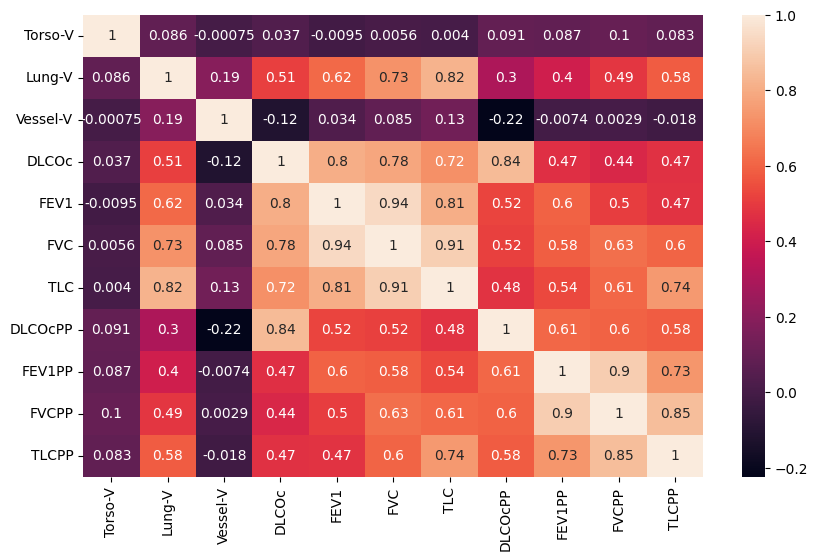

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df_new.corr(), ax=ax, annot=True)